# Data Analyst Professional Practical Exam Submission

**You can use any tool that you want to do your analysis and create visualizations. Use this template to write up your summary for submission.**

You can use any markdown formatting you wish. If you are not familiar with Markdown, read the [Markdown Guide](https://s3.amazonaws.com/talent-assets.datacamp.com/Markdown+Guide.pdf) before you start.


## 📝 Task List

Your written report should include written text summaries and graphics of the following:
- Data validation:   
  - Describe validation and cleaning steps for every column in the data 
- Exploratory Analysis:  
  - Include two different graphics showing single variables only to demonstrate the characteristics of data  
  - Include at least one graphic showing two or more variables to represent the relationship between features
  - Describe your findings
- Definition of a metric for the business to monitor  
  - How should the business use the metric to monitor the business problem
  - Can you estimate initial value(s) for the metric based on the current data
- Final summary including recommendations that the business should undertake

*Start writing report here..*

# PART 1: Data Validation

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
product_sales = pd.read_csv('product_sales.csv')

In [3]:
product_sales.head(10)

,week,sales_method,customer_id,nb_sold,revenue,years_as_customer,nb_site_visits,state
0,2,Email,2e72d641-95ac-497b-bbf8-4861764a7097,10,NaN,0,24,Arizona
1,6,Email + Call,3998a98d-70f5-44f7-942e-789bb8ad2fe7,15,225.47,1,28,Kansas
2,5,Call,d1de9884-8059-4065-b10f-86eef57e4a44,11,52.55,6,26,Wisconsin
3,4,Email,78aa75a4-ffeb-4817-b1d0-2f030783c5d7,11,NaN,3,25,Indiana
4,3,Email,10e6d446-10a5-42e5-8210-1b5438f70922,9,90.49,0,28,Illinois
5,6,Call,6489e678-40f2-4fed-a48e-d0dff9c09205,13,65.01,10,24,Mississippi
6,4,Email,eb6bd5f1-f115-4e4b-80a6-5e67fcfbfb94,11,113.38,9,28,Georgia
7,1,Email,047df079-071b-4380-9012-2bfe9bce45d5,10,99.94,1,22,Oklahoma
8,5,Email,771586bd-7b64-40be-87df-afe884d2af9e,11,108.34,10,31,Massachusetts
9,5,Call,56491dae-bbe7-49f0-a651-b823a01103d8,11,53.82,7,23,Missouri


In [4]:
df = product_sales.copy()

### 1. Check data

In [5]:
# Checking for missing values and finding each column data type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   week               15000 non-null  int64  
 1   sales_method       15000 non-null  object 
 2   customer_id        15000 non-null  object 
 3   nb_sold            15000 non-null  int64  
 4   revenue            13926 non-null  float64
 5   years_as_customer  15000 non-null  int64  
 6   nb_site_visits     15000 non-null  int64  
 7   state              15000 non-null  object 
dtypes: float64(1), int64(4), object(3)
memory usage: 937.6+ KB


=> We can see there are some missing value from revenue column!
#### Let's check each column for data validation and its need for cleaning.

In [6]:
# 1. Check missing value
df.isna().sum()

week                    0
sales_method            0
customer_id             0
nb_sold                 0
revenue              1074
years_as_customer       0
nb_site_visits          0
state                   0
dtype: int64

=> There are 1074 missing value in revenue column!

In [7]:
 # 2. Data validation: Check the unique values to identify any unexpected or erroneous data.
df.nunique()

week                     6
sales_method             5
customer_id          15000
nb_sold                 10
revenue               6743
years_as_customer       42
nb_site_visits          27
state                   50
dtype: int64

=> In sales_method column we see 5 different method which is wrong (we should have 3 type of methods)

In [8]:
# 3. Check outlier: Using summary statistics such as mean, median,standard deviation, and quartiles, we can identify outliers in numeric columns.
df.describe()

,week,nb_sold,revenue,years_as_customer,nb_site_visits
count,15000.000000,15000.000000,13926.000000,15000.000000,15000.000000
mean,3.098267,10.084667,93.934943,4.965933,24.990867
std,1.656420,1.812213,47.435312,5.044952,3.500914
min,1.000000,7.000000,32.540000,0.000000,12.000000
25%,2.000000,9.000000,52.470000,1.000000,23.000000
50%,3.000000,10.000000,89.500000,3.000000,25.000000
75%,5.000000,11.000000,107.327500,7.000000,27.000000
max,6.000000,16.000000,238.320000,63.000000,41.000000


=> there are outliers in years_as_customer, because The company was founded in 1984 and is currently operating in 2024 and the maximum number of years customers have purchased from us is 40 years => we can't have a customers since 63 years ago!

### 2. Handle data

#### a. Handle unique value: sale_method column

In [9]:
# We should have 3 unique values in sales_method column. 
df['sales_method'].unique()

array(['Email', 'Email + Call', 'Call', 'em + call', 'email'],
      dtype=object)

In [10]:
# Standardize the values in the 'sales_method' column by replacing 'em + call' with 'Email + Call' and 'email' with 'Email'
df.sales_method = df.sales_method.replace({'em + call':'Email + Call','email':'Email'})
print(f'Unique values in the sales_method column after replacement:{df.sales_method.unique()}')

Unique values in the sales_method column after replacement:['Email' 'Email + Call' 'Call']


#### b. Handle outlier: year_as_customer

In [11]:
# Values greater than 40 in years_as_customer are wrong and we should consider them as outliers
df[df['years_as_customer']>40]

,week,sales_method,customer_id,nb_sold,revenue,years_as_customer,nb_site_visits,state
13741,2,Email,18919515-a618-430c-9a05-2c7d8fea96af,10,97.22,63,24,California
13800,4,Call,2ea97d34-571d-4e1b-95be-fea1c404649f,10,50.47,47,27,California


 => There are only two records as years_as_customer outliers, so we can easily drop them.

In [12]:
df = df[df.years_as_customer <= 40]

In [13]:
# Check the number of records after filtering
print("Number of records after filtering:", len(df))

Number of records after filtering: 14998


#### c. Handle missing value: revenue column

In [14]:
# Proportion of missing values relative to the total entries in the revenue column
(df.revenue.isna().sum()/df.revenue.count())*100

7.713300775639184

=> There are more than 5 percent missing values in revenue column, so we can not easily drop them unless we examine randomness of missing values. If they are missing completely at random (MCAR) or missing at random (MAR), dropping them may be less problematic. However, if they are missing not at random (MNAR), dropping them could introduce bias.To conduct a statistical test to determine if there is a relationship between missing values in the 'revenue' column and the 'sales_method' column, we can use a chi-square test of independence. This test is appropriate  when both variables are categorical, so we first create a categorical revenue column

In [15]:
# Replace NaN values with "Null" and non-NaN values with "Not_Null"
df['revenue_category'] = df['revenue'].fillna('Null').map(lambda x: 'Not_Null' if x != 'Null' else x)

In [16]:
# Check the unique values in the 'revenue_category' column
df.revenue_category.unique()

array(['Null', 'Not_Null'], dtype=object)

In [17]:
df.head(10)

,week,sales_method,customer_id,nb_sold,revenue,years_as_customer,nb_site_visits,state,revenue_category
0,2,Email,2e72d641-95ac-497b-bbf8-4861764a7097,10,NaN,0,24,Arizona,Null
1,6,Email + Call,3998a98d-70f5-44f7-942e-789bb8ad2fe7,15,225.47,1,28,Kansas,Not_Null
2,5,Call,d1de9884-8059-4065-b10f-86eef57e4a44,11,52.55,6,26,Wisconsin,Not_Null
3,4,Email,78aa75a4-ffeb-4817-b1d0-2f030783c5d7,11,NaN,3,25,Indiana,Null
4,3,Email,10e6d446-10a5-42e5-8210-1b5438f70922,9,90.49,0,28,Illinois,Not_Null
5,6,Call,6489e678-40f2-4fed-a48e-d0dff9c09205,13,65.01,10,24,Mississippi,Not_Null
6,4,Email,eb6bd5f1-f115-4e4b-80a6-5e67fcfbfb94,11,113.38,9,28,Georgia,Not_Null
7,1,Email,047df079-071b-4380-9012-2bfe9bce45d5,10,99.94,1,22,Oklahoma,Not_Null
8,5,Email,771586bd-7b64-40be-87df-afe884d2af9e,11,108.34,10,31,Massachusetts,Not_Null
9,5,Call,56491dae-bbe7-49f0-a651-b823a01103d8,11,53.82,7,23,Missouri,Not_Null


In [18]:
# Conduct a chi-square test of independence between the 'sales_method' and 'revenue_category' columns, we first need to create a contingency table representing the frequencies of each combination of categories.Then, we can use the chi2_contingency function from the scipy.stats module to perform the test.
from scipy.stats import chi2_contingency
contingency_table = pd.crosstab(df.sales_method,df.revenue_category)
contingency_table

revenue_category,Not_Null,Null
sales_method,,
Call,4780,181
Email,6921,544
Email + Call,2223,349


In [19]:
# Perform the chi-square test
chi2, p_value, _, _ = chi2_contingency(contingency_table)

In [20]:
# Print the results
print("\nChi-square statistic:", chi2)
print("p-value:", p_value)


Chi-square statistic: 251.11783987671868
p-value: 2.954295391738752e-55


In [21]:
# Interpret the results
alpha = 0.05  # significance level
if p_value < alpha:
    print("\nThere is a significant relationship between 'sales_method' and 'revenue_category'.")
else:
    print("\nThere is no significant relationship between 'sales_method' and 'revenue_category'.")


There is a significant relationship between 'sales_method' and 'revenue_category'.


 => Because there is a significant relationship between 'sales_method' and 'revenue_category', we can not easily drop missing values. In such cases, simply dropping missing values may introduce bias into your analysis.

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt


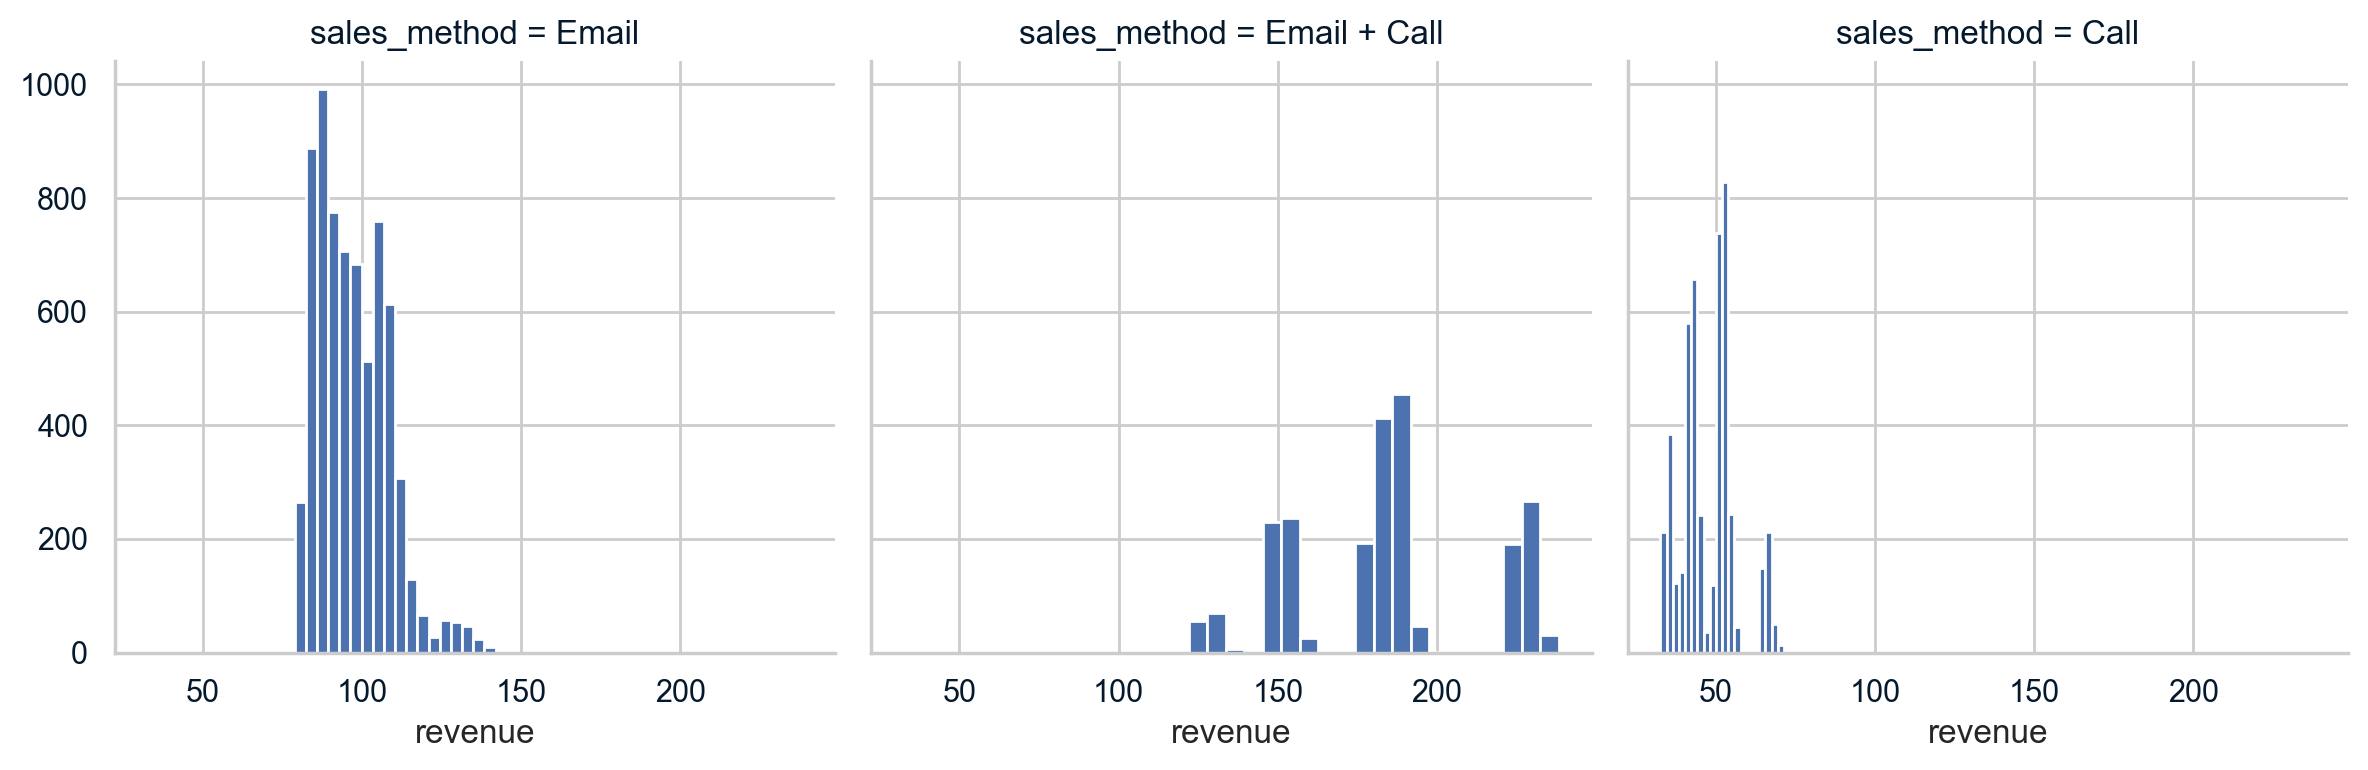

In [23]:
# Set the style of seaborn
sns.set(style="whitegrid")
# Create a facet grid using seaborn
g = sns.FacetGrid(df, col = 'sales_method',col_wrap= 3, height= 4)
g.map(plt.hist,"revenue",bins = 20)

=> When the distribution of revenue for each sales method is not normal, it's generally advised to use the median for imputation rather than the mean.

In [24]:
# Function to perform stratified imputation
def stratified_imputation(group):
    # Calculate median of 'revenue' within each group
    median_revenue = group['revenue'].median()
    # Impute missing values with the median within each group
    group['revenue'] = group['revenue'].fillna(median_revenue)
    
    return group

# Group the DataFrame by 'sales_method' and apply stratified imputation
df_imputed = df.groupby('sales_method').apply(stratified_imputation)

# Check if there are still any missing values in 'revenue' column
missing_values = df_imputed['revenue'].isnull().sum()
print("Number of missing values after imputation:", missing_values)

Number of missing values after imputation: 0


In [25]:
df = df_imputed.reset_index()

In [26]:
df.head(15)

,index,week,sales_method,customer_id,nb_sold,revenue,years_as_customer,nb_site_visits,state,revenue_category
0,0,2,Email,2e72d641-95ac-497b-bbf8-4861764a7097,10,95.58,0,24,Arizona,Null
1,1,6,Email + Call,3998a98d-70f5-44f7-942e-789bb8ad2fe7,15,225.47,1,28,Kansas,Not_Null
2,2,5,Call,d1de9884-8059-4065-b10f-86eef57e4a44,11,52.55,6,26,Wisconsin,Not_Null
3,3,4,Email,78aa75a4-ffeb-4817-b1d0-2f030783c5d7,11,95.58,3,25,Indiana,Null
4,4,3,Email,10e6d446-10a5-42e5-8210-1b5438f70922,9,90.49,0,28,Illinois,Not_Null
5,5,6,Call,6489e678-40f2-4fed-a48e-d0dff9c09205,13,65.01,10,24,Mississippi,Not_Null
6,6,4,Email,eb6bd5f1-f115-4e4b-80a6-5e67fcfbfb94,11,113.38,9,28,Georgia,Not_Null
7,7,1,Email,047df079-071b-4380-9012-2bfe9bce45d5,10,99.94,1,22,Oklahoma,Not_Null
8,8,5,Email,771586bd-7b64-40be-87df-afe884d2af9e,11,108.34,10,31,Massachusetts,Not_Null
9,9,5,Call,56491dae-bbe7-49f0-a651-b823a01103d8,11,53.82,7,23,Missouri,Not_Null


# PART 2: Exploratory Analysis
To answer the customer questions, we conducted an exploratory analysis using various graphical and descriptive methods.

In [27]:
eda = df.copy()

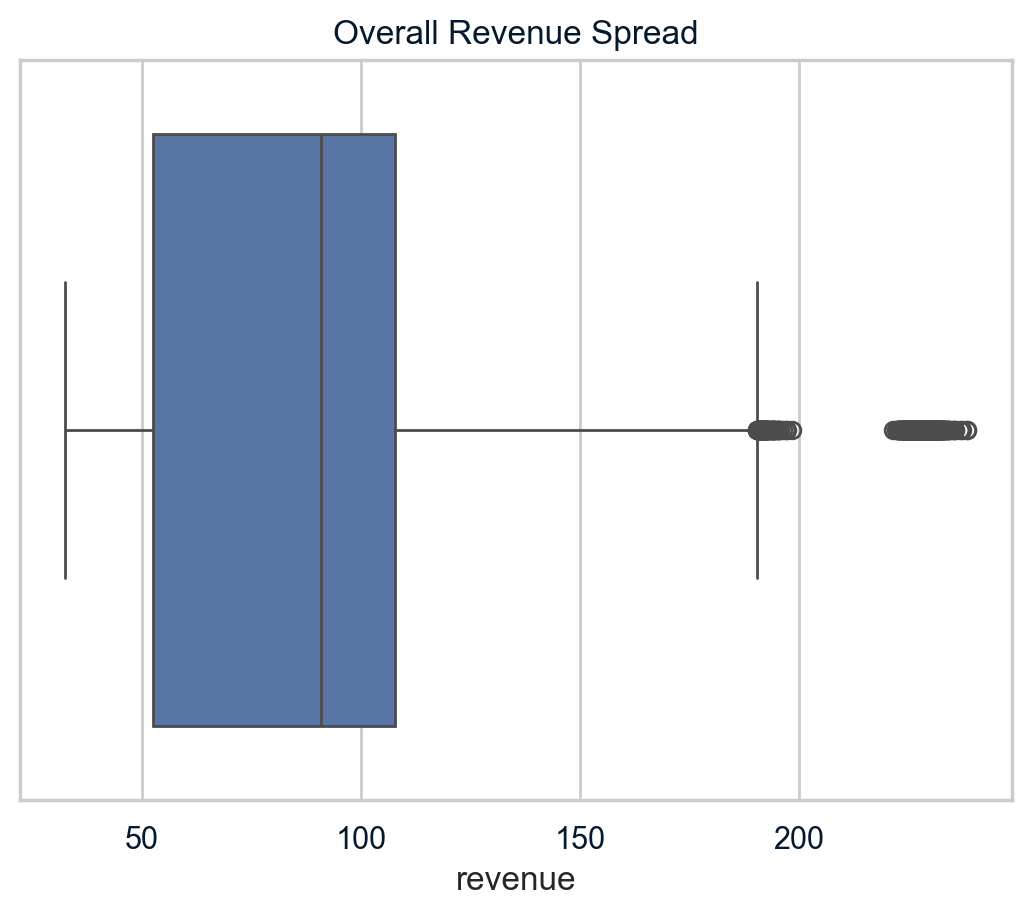

In [28]:
# Overall Revenue Method
sns.boxplot(data = eda, x = 'revenue')
plt.title('Overall Revenue Spread')
plt.xlabel('revenue')
plt.show()

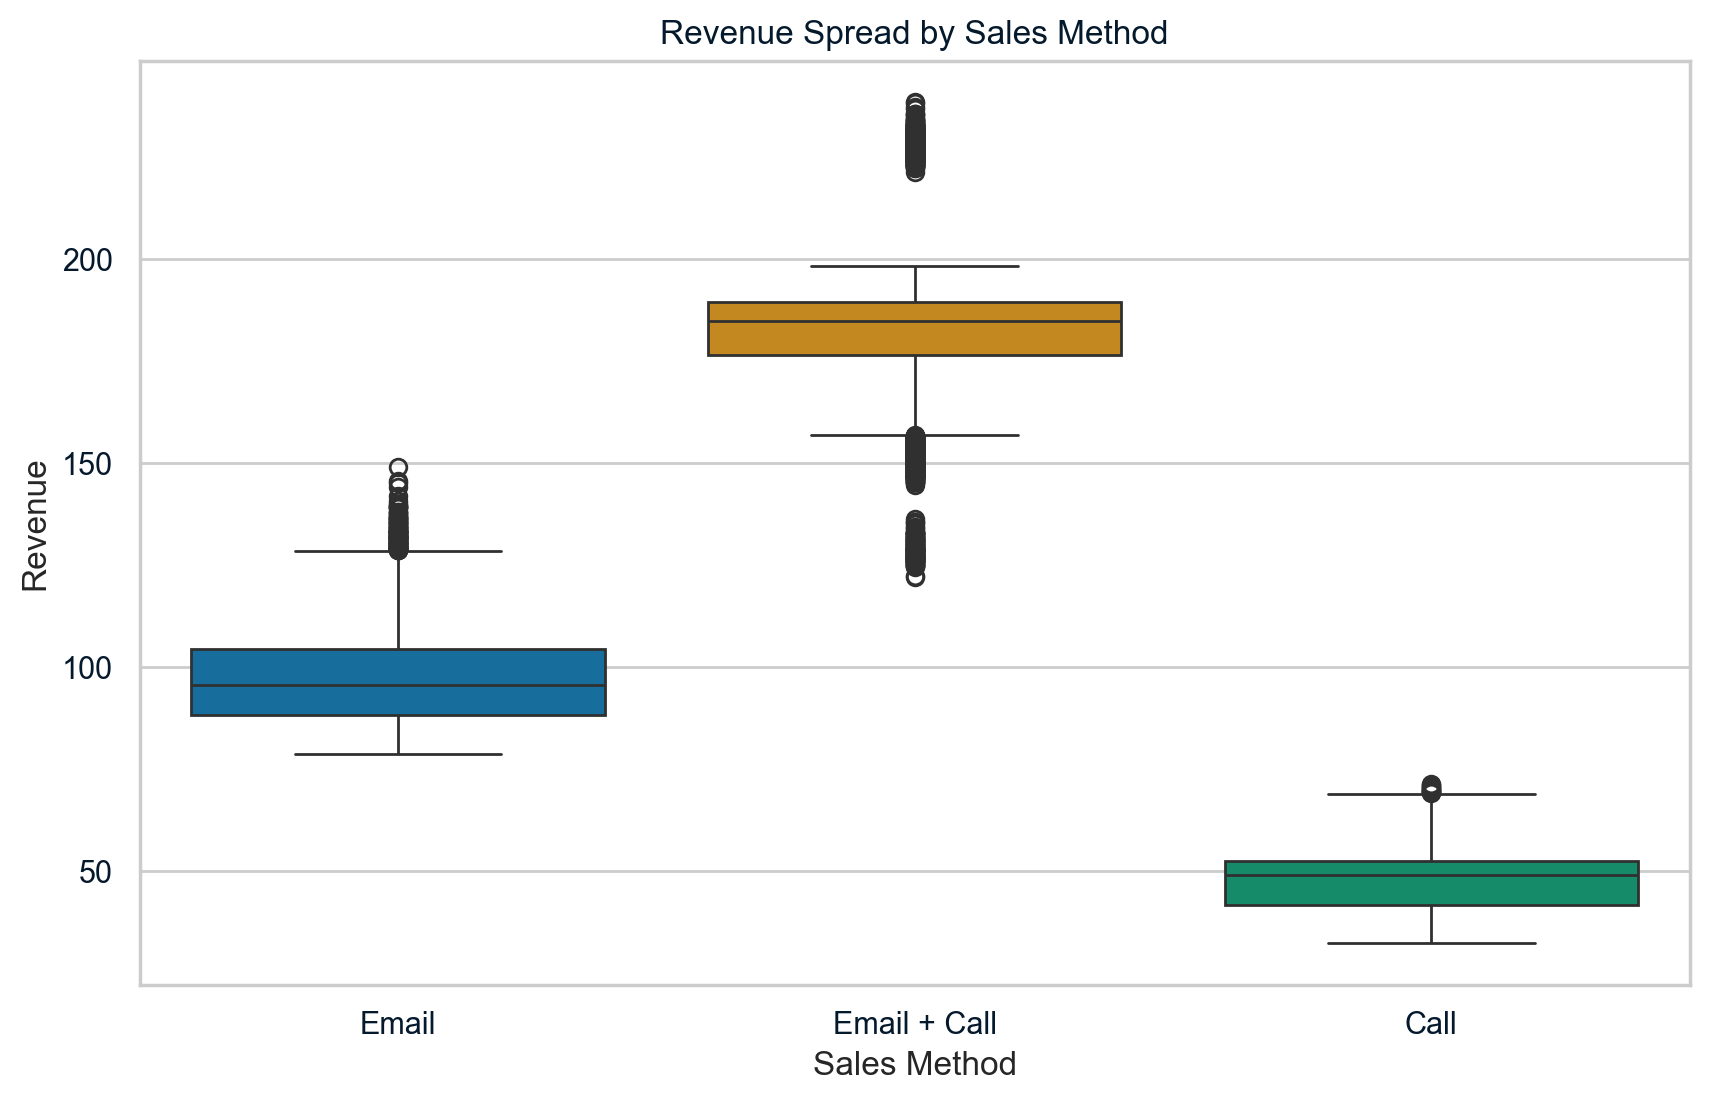

In [29]:
# Revenue spread for each sales method
plt.figure(figsize= (10,6))
sns.boxplot(data = eda, x ='sales_method', y = 'revenue', hue = 'sales_method',palette='colorblind')
plt.title('Revenue Spread by Sales Method')
plt.xlabel('Sales Method')
plt.ylabel('Revenue')
plt.show()

sales_method
Call             49.05
Email            95.58
Email + Call    184.74
Name: revenue, dtype: float64


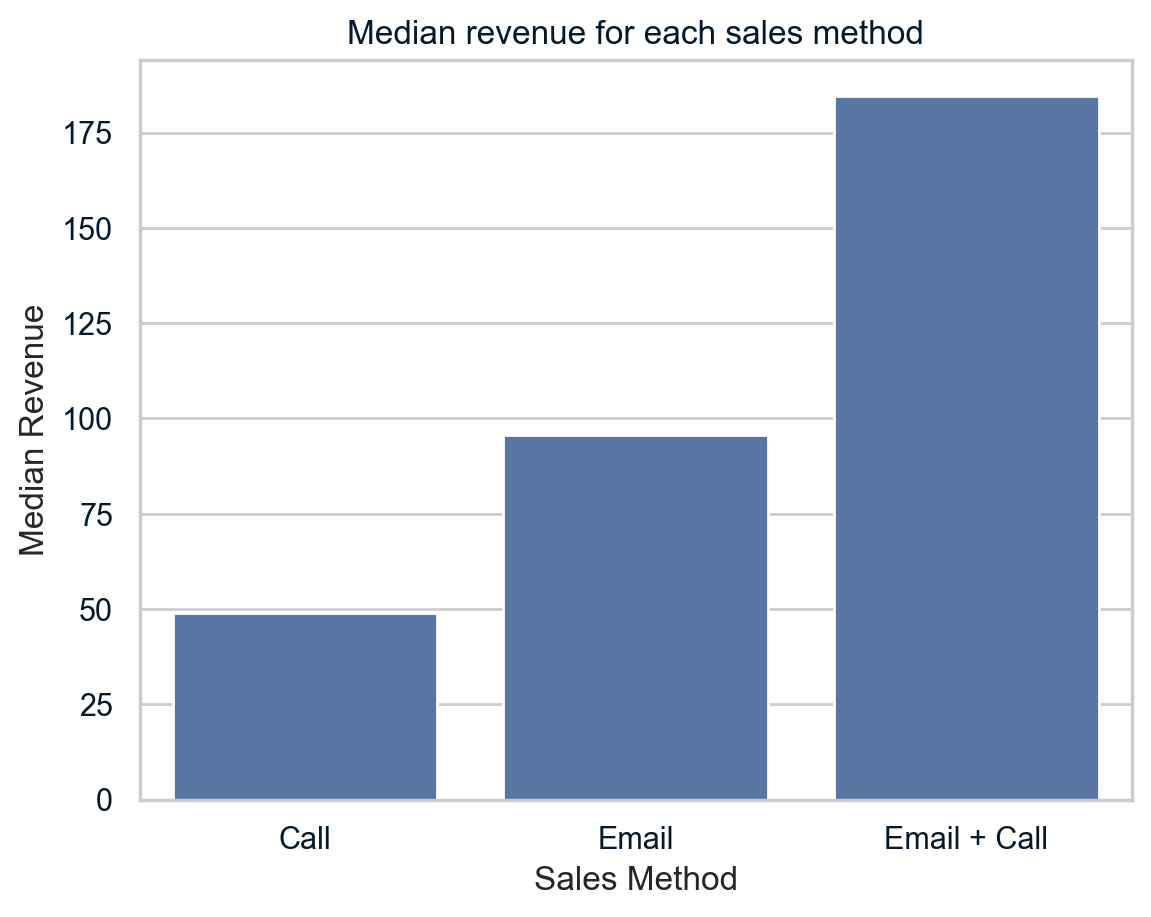

In [30]:
# Median revenue for each sales method
median_df = eda.groupby('sales_method')['revenue'].median()

# To display the resulting DataFrame
print(median_df)
# To display visualization
sns.barplot(data=median_df)
plt.title('Median revenue for each sales method')
plt.xlabel('Sales Method')
plt.ylabel('Median Revenue')
plt.show()

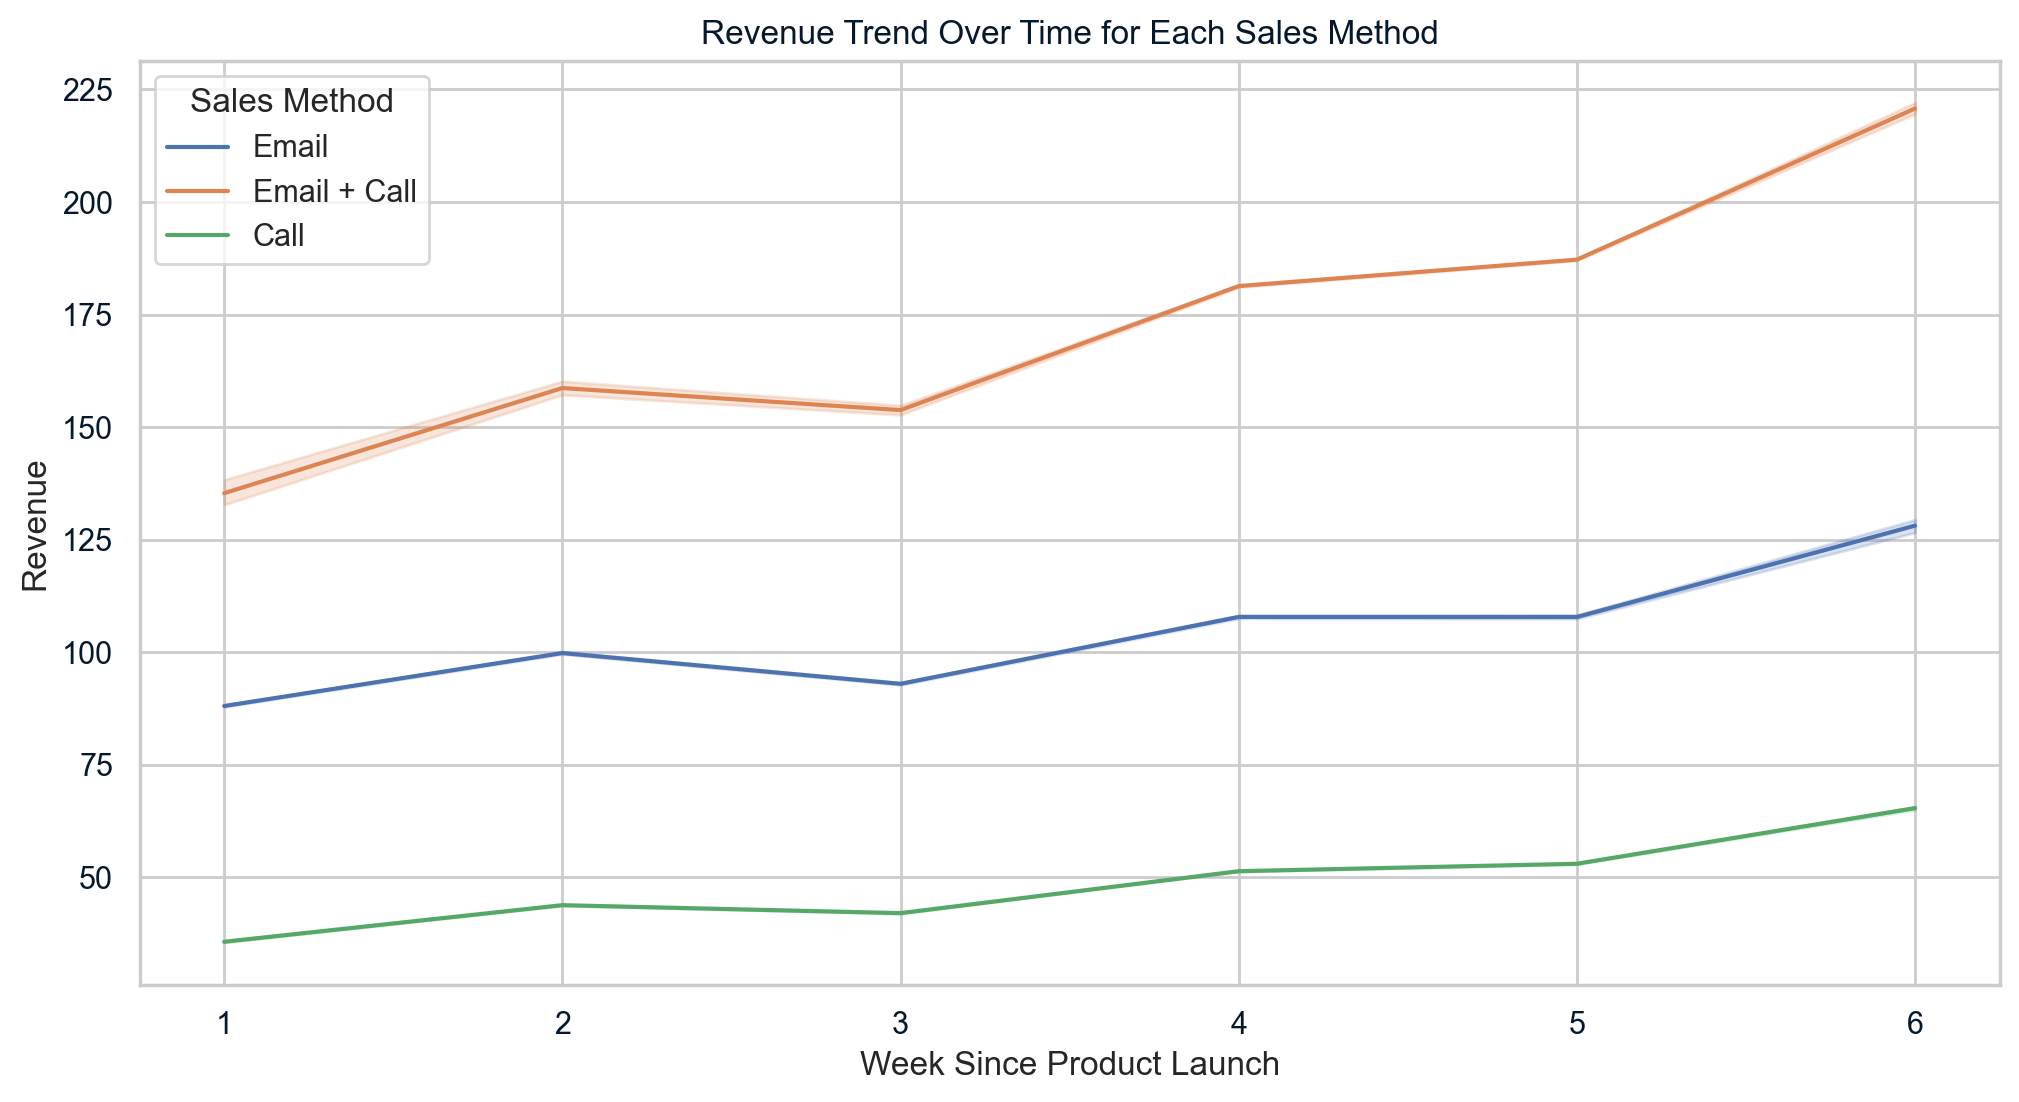

In [31]:
# To analyze the difference in revenue over time for each sales method, we can create line plots showing the trend of revenue over the weeks since the product launch
plt.figure(figsize=(12,6))
sns.lineplot(data=eda,x='week',y = 'revenue', hue ='sales_method')
plt.title('Revenue Trend Over Time for Each Sales Method')
plt.xlabel('Week Since Product Launch')
plt.ylabel('Revenue')
plt.legend(title='Sales Method')
plt.show()

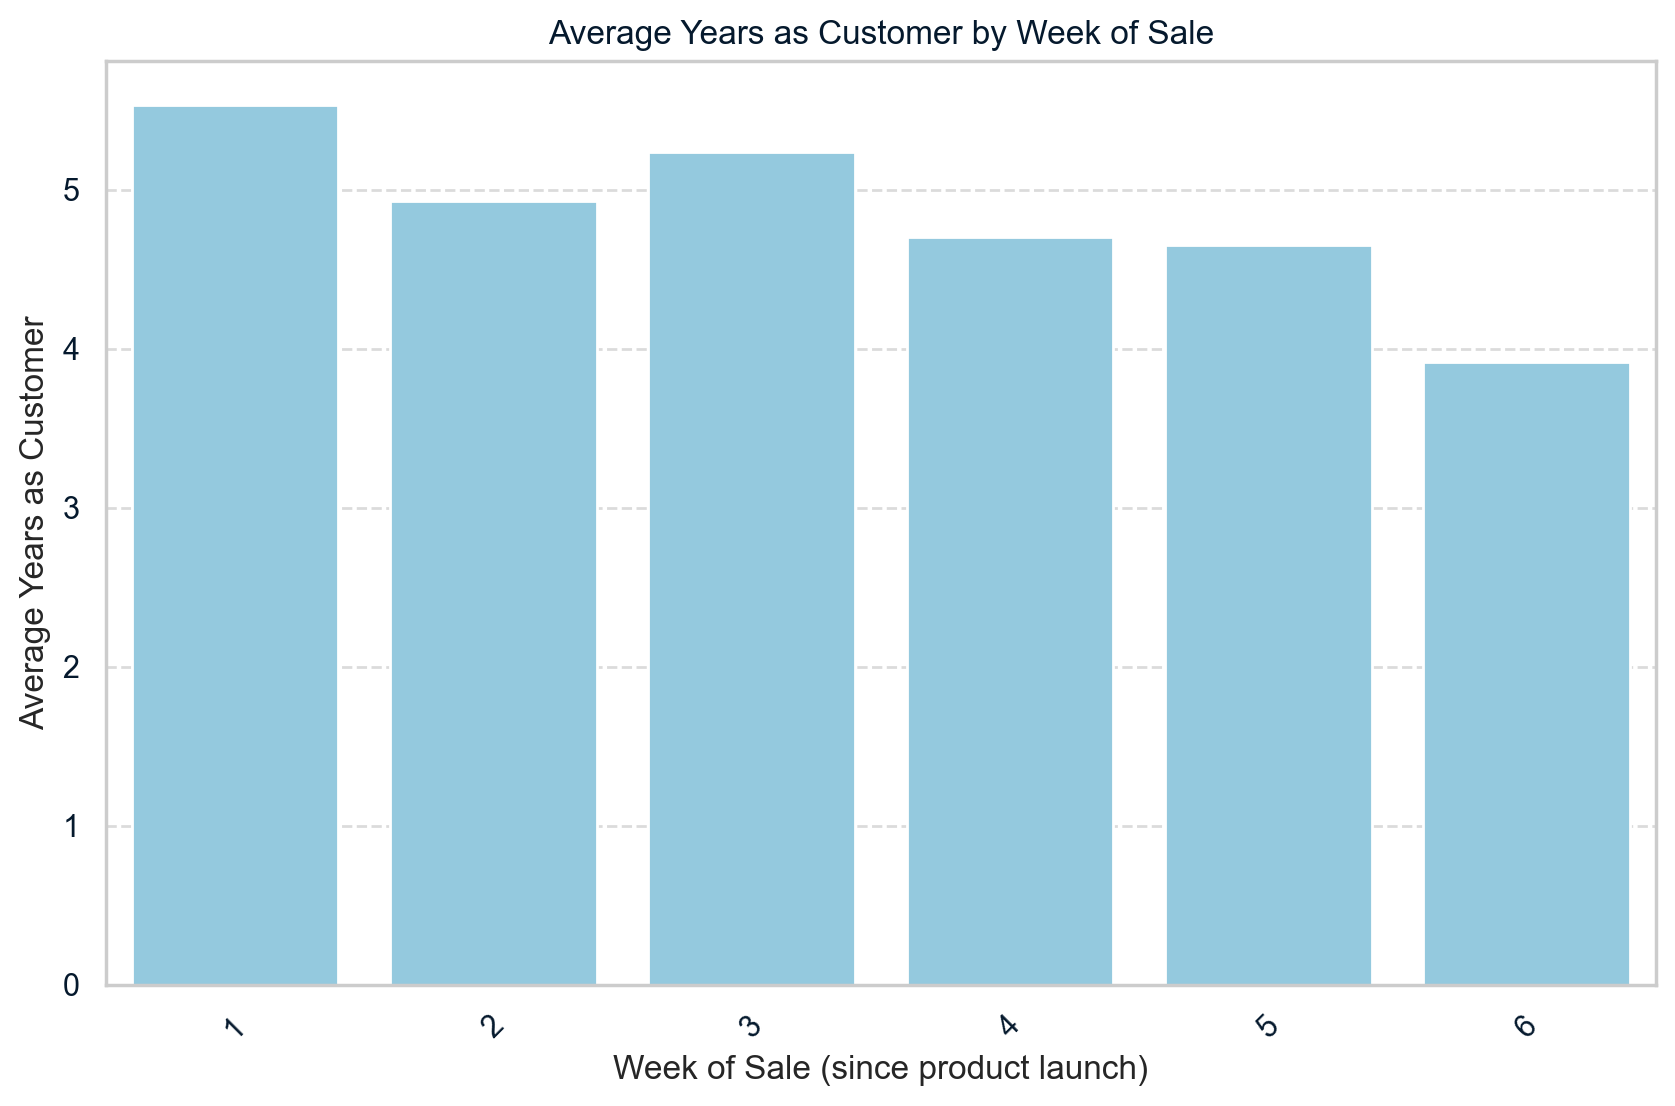

In [32]:
avg_years_by_week = eda.groupby('week').years_as_customer.mean().reset_index()
avg_years_by_week
plt.figure(figsize=(10,6))
sns.barplot(data= avg_years_by_week, x='week',y= 'years_as_customer',color = 'skyblue')
plt.title('Average Years as Customer by Week of Sale')
plt.xlabel('Week of Sale (since product launch)')
plt.ylabel('Average Years as Customer')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [33]:
# Calculate the correlation between week and years_as_customer
correlation = eda.week.corr(eda.years_as_customer)
# Print the correlation
print("Correlation between week and years_as_customer:", correlation)

Correlation between week and years_as_customer: -0.08268829695786738


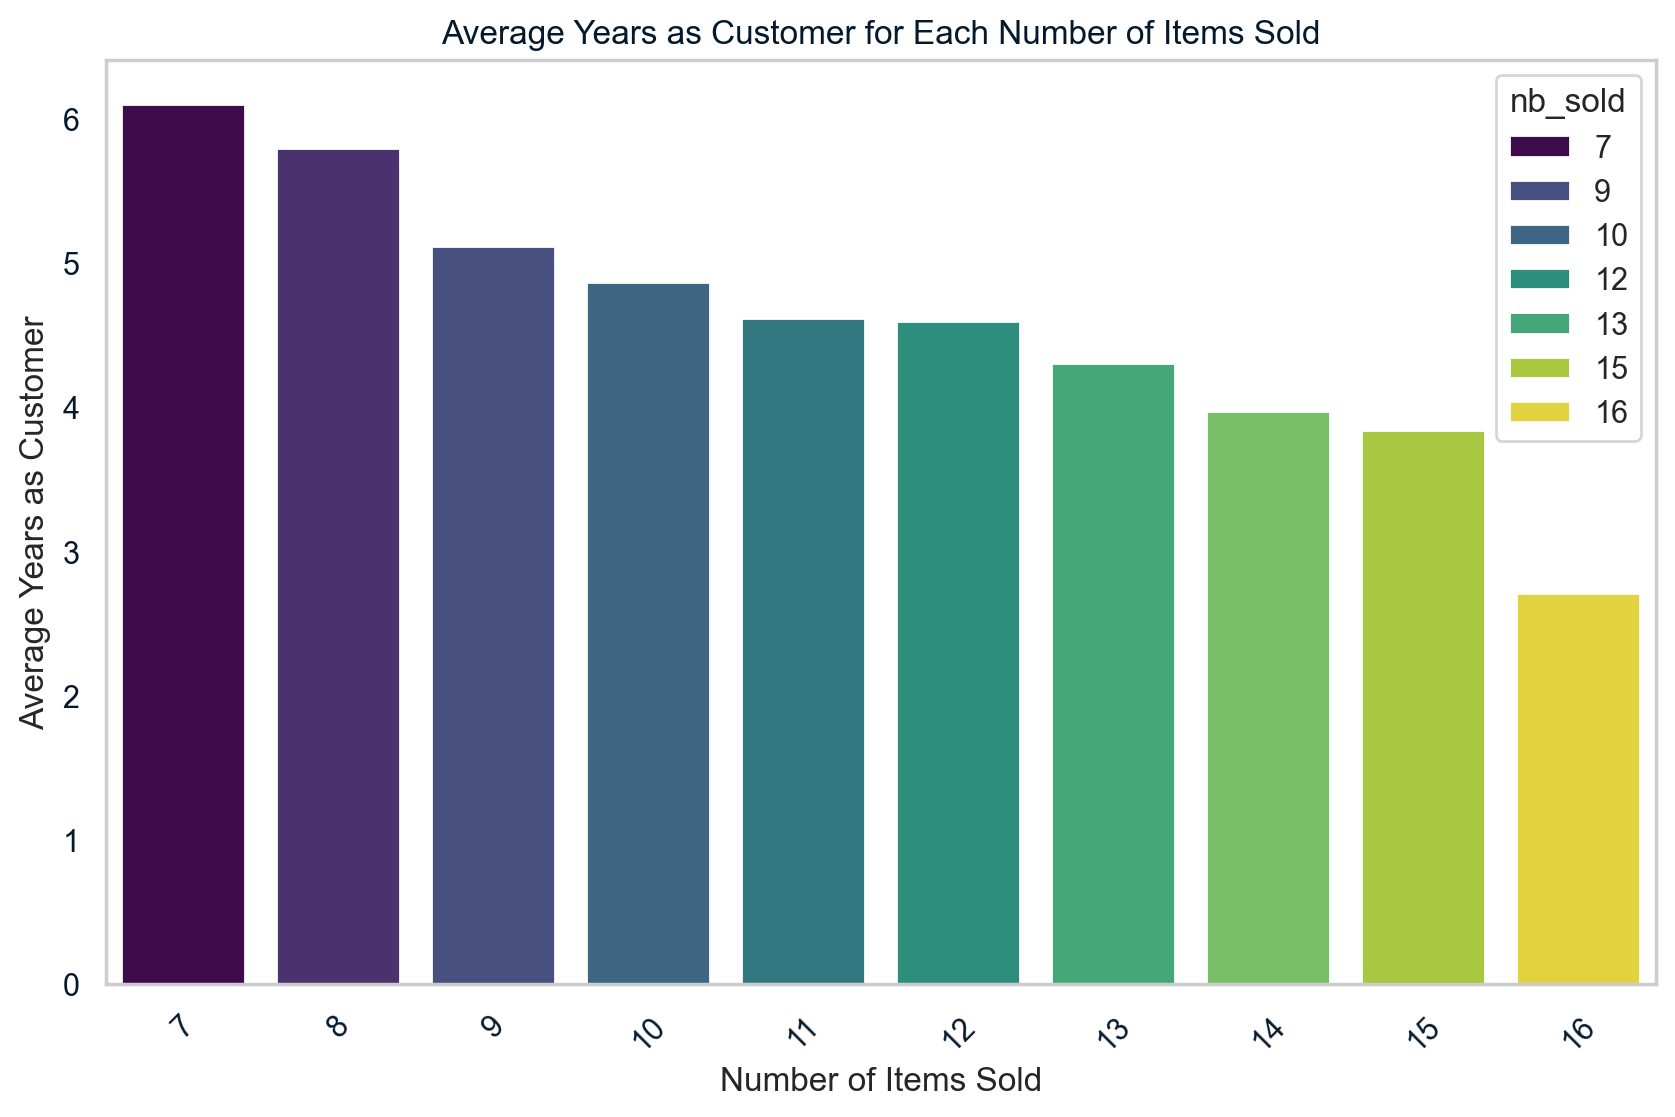

In [34]:
# Calculate the average years as customer for each nb_sold group
avg_years_per_nb_sold = eda.groupby('nb_sold')['years_as_customer'].mean().reset_index()

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(data=avg_years_per_nb_sold, x='nb_sold', y='years_as_customer', hue='nb_sold', palette='viridis')
plt.title('Average Years as Customer for Each Number of Items Sold')
plt.xlabel('Number of Items Sold')
plt.ylabel('Average Years as Customer')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(axis='y')  # Add gridlines for y-axis
plt.show()

In [35]:
# To calculate the correlation between years_as_customer and nb_sold, you can use the corr() function in pandas.

# Calculate the correlation between years_as_customer and nb_sold
correlation = eda['years_as_customer'].corr(eda['nb_sold'])

# Print the correlation
print("Correlation between years_as_customer and nb_sold:", correlation)

Correlation between years_as_customer and nb_sold: -0.09972786463847658


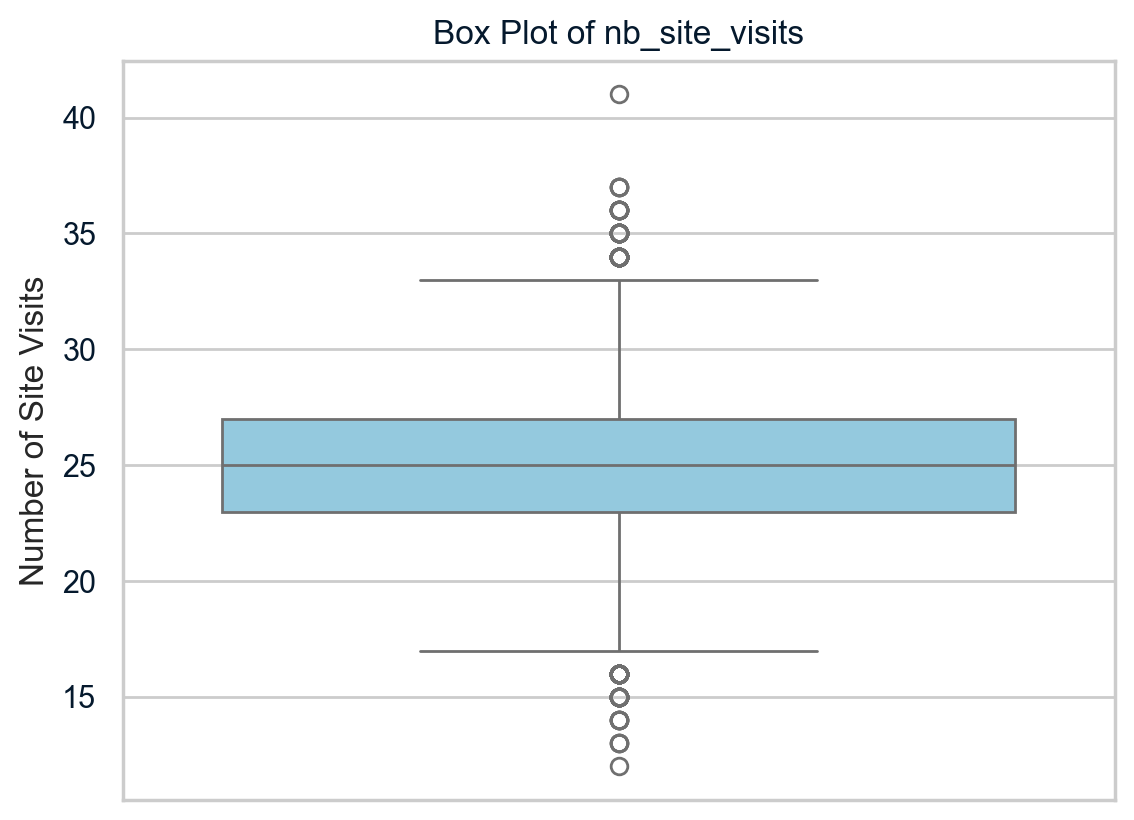

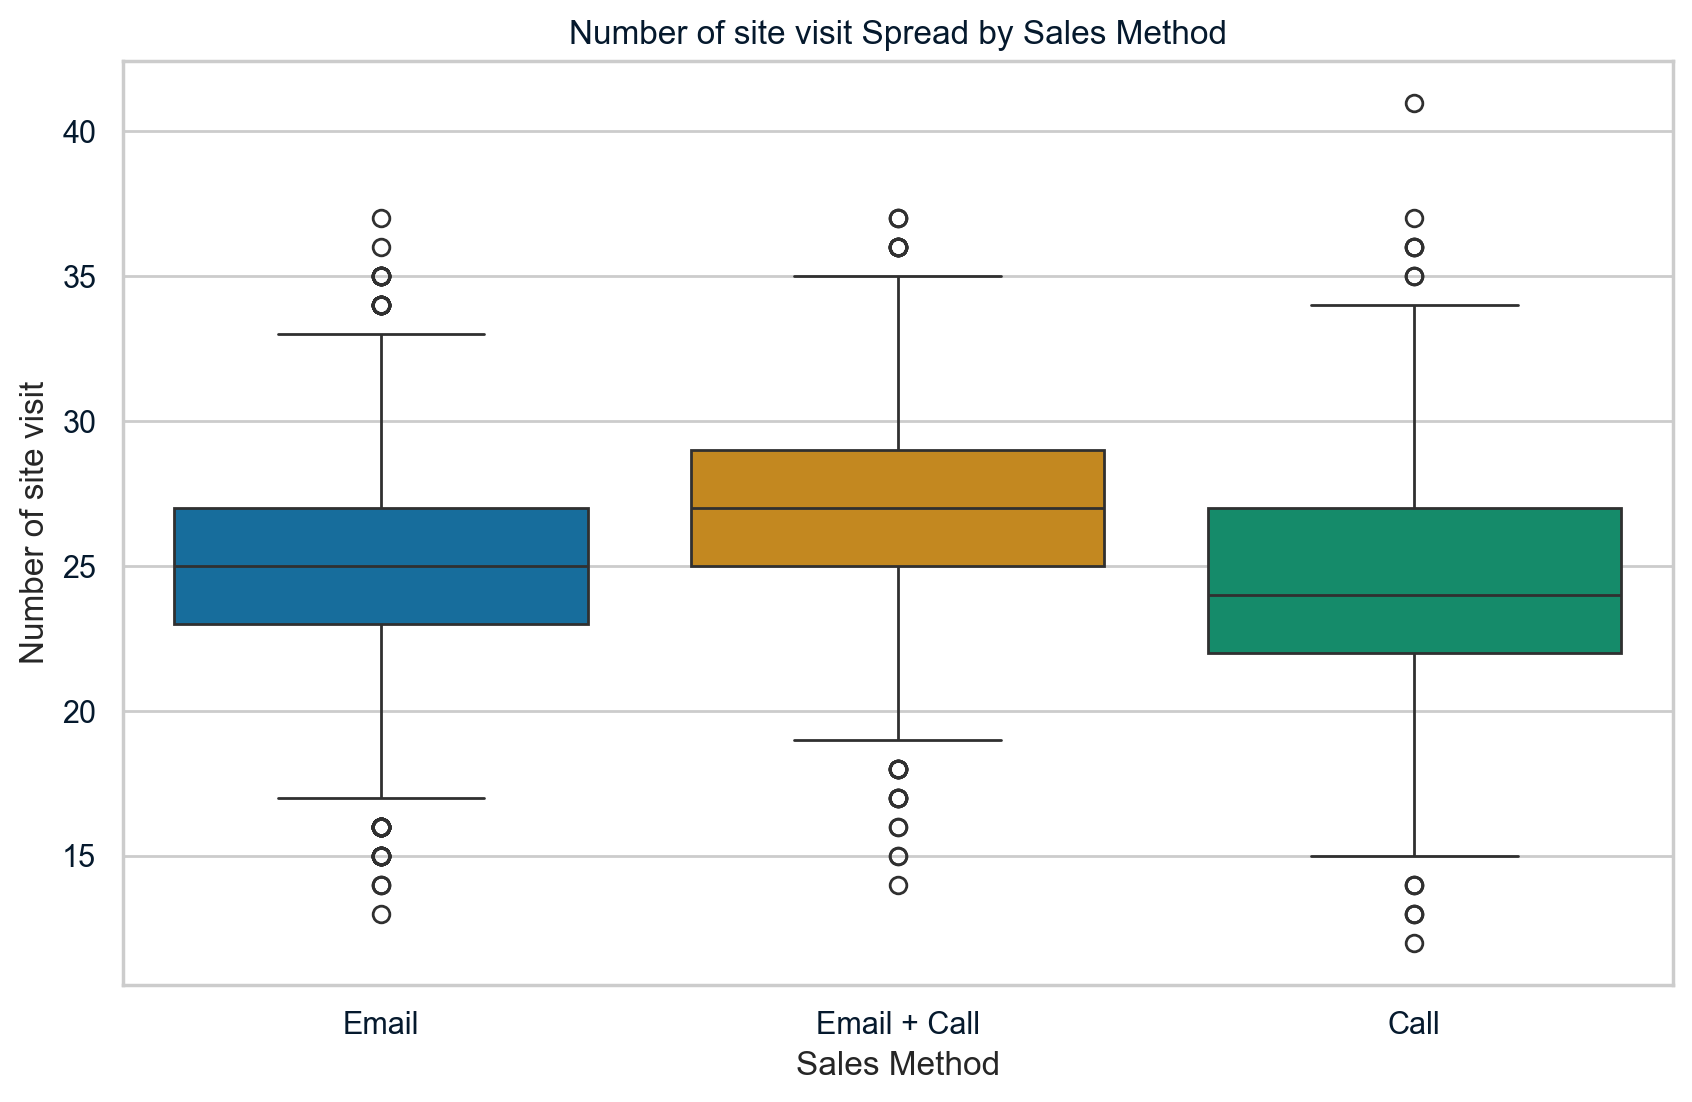

In [36]:
# Overall number of site visit

# Create the box plot
sns.boxplot(data=eda, y='nb_site_visits', color='skyblue')

# Set the title and labels
plt.title('Box Plot of nb_site_visits')
plt.ylabel('Number of Site Visits')

# Show the plot
plt.show()


# Number of site visit for each sales method

plt.figure(figsize=(10, 6))
sns.boxplot(data=eda, x='sales_method', y='nb_site_visits', hue='sales_method', palette='colorblind')
plt.title('Number of site visit Spread by Sales Method')
plt.xlabel('Sales Method')
plt.ylabel('Number of site visit')
plt.show()

In [37]:
# Count the number of customers who visited more than 40 times
num_customers_visited_more_than_40 = len(eda[eda['nb_site_visits'] > 40])

print("Number of customers who visited more than 40 times:", num_customers_visited_more_than_40)

Number of customers who visited more than 40 times: 1


In [38]:
# Group the data by state and sum the revenue for each state
revenue_by_state = eda.groupby('state')['revenue'].sum().reset_index()

# Sort the states based on their total revenue
revenue_by_state_sorted = revenue_by_state.sort_values(by='revenue', ascending=False)

# Get the top 5 states by revenue
top_5_states_by_revenue = revenue_by_state_sorted.head(5)

print("Top 5 states by revenue:")
print(top_5_states_by_revenue)

Top 5 states by revenue:
         state    revenue
4   California  176729.57
42       Texas  114691.45
31    New York   90651.87
8      Florida   86781.53
12    Illinois   57579.82


In [39]:
# Group by 'state' and count missing values in 'revenue' column
missing_values_by_state = eda[eda.revenue_category == 'Null'].groupby('state').size().reset_index(name='missing_count').sort_values(by = 'missing_count', ascending = False)
missing_values_by_state

,state,missing_count
4,California,133
42,Texas,78
8,Florida,78
31,New York,66
34,Ohio,46
37,Pennsylvania,45
12,Illinois,41
21,Michigan,32
41,Tennessee,32
29,New Jersey,32


In [40]:
# Group by 'state' and count missing values in 'revenue' column
missing_values_by_state = eda[eda.revenue_category == 'Null'].groupby('state').size().reset_index(name='missing_count')

# Calculate total records for each state
total_records_by_state = eda.groupby('state').size().reset_index(name='total_count')
# Merge the two DataFrames on 'state'
state = missing_values_by_state.merge(total_records_by_state, on='state')
# Calculate percentage of missing values for each state
state['percentage_missing'] = (state.missing_count/state.total_count)*100
state.sort_values(by = 'percentage_missing',ascending = False)

,state,missing_count,total_count,percentage_missing
7,Delaware,7,34,20.588235
33,North Dakota,5,30,16.666667
1,Alaska,5,40,12.500000
3,Arkansas,14,132,10.606061
28,New Hampshire,5,53,9.433962
47,West Virginia,8,85,9.411765
41,Tennessee,32,340,9.411765
15,Kansas,13,142,9.154930
8,Florida,78,904,8.628319
20,Massachusetts,24,294,8.163265


# PART 3: METRIC

Average Revenue per Customer Visit is a metric that measures the average amount of revenue generated by each visit to the company's website. It helps in understanding the effectiveness of the company's online sales strategy and the value derived from each interaction with customers on the website.

How to Use the Metric:

Monitor Trends: Track the average revenue per customer visit over time to identify trends and patterns. Increasing trends may indicate improvements in online sales strategies or customer engagement, while decreasing trends may signal areas for improvement.

Benchmarking: Compare the average revenue per visit against industry benchmarks or competitors' performance to assess the company's competitiveness and identify areas for improvement.

Performance Evaluation: Use the metric to evaluate the effectiveness of marketing campaigns, website optimizations, or changes in sales strategies. Identify high-performing periods and factors contributing to success.

In [41]:
total_revenue = eda['revenue'].sum()
total_visits = eda['nb_site_visits'].sum()
average_revenue_per_visit = total_revenue / total_visits
print("Initial Average Revenue per Visit:", average_revenue_per_visit)

Initial Average Revenue per Visit: 3.824152241657151


It provides insights into the effectiveness of each sales method in converting website visits into revenue and helps in identifying which sales methods are most successful in driving revenue per visit.

In [42]:
# Calculate total revenue and total visits for each sales method
total_revenue_by_method = eda.groupby('sales_method')['revenue'].sum()
total_visits_by_method = eda.groupby('sales_method')['nb_site_visits'].sum()

# Calculate average revenue per visit for each sales method
average_revenue_per_visit_by_method = total_revenue_by_method / total_visits_by_method
print("Initial Average Revenue per Visit (by Sales Method):")
print(average_revenue_per_visit_by_method)

Initial Average Revenue per Visit (by Sales Method):
sales_method
Call            1.951001
Email           3.919088
Email + Call    6.865501
dtype: float64


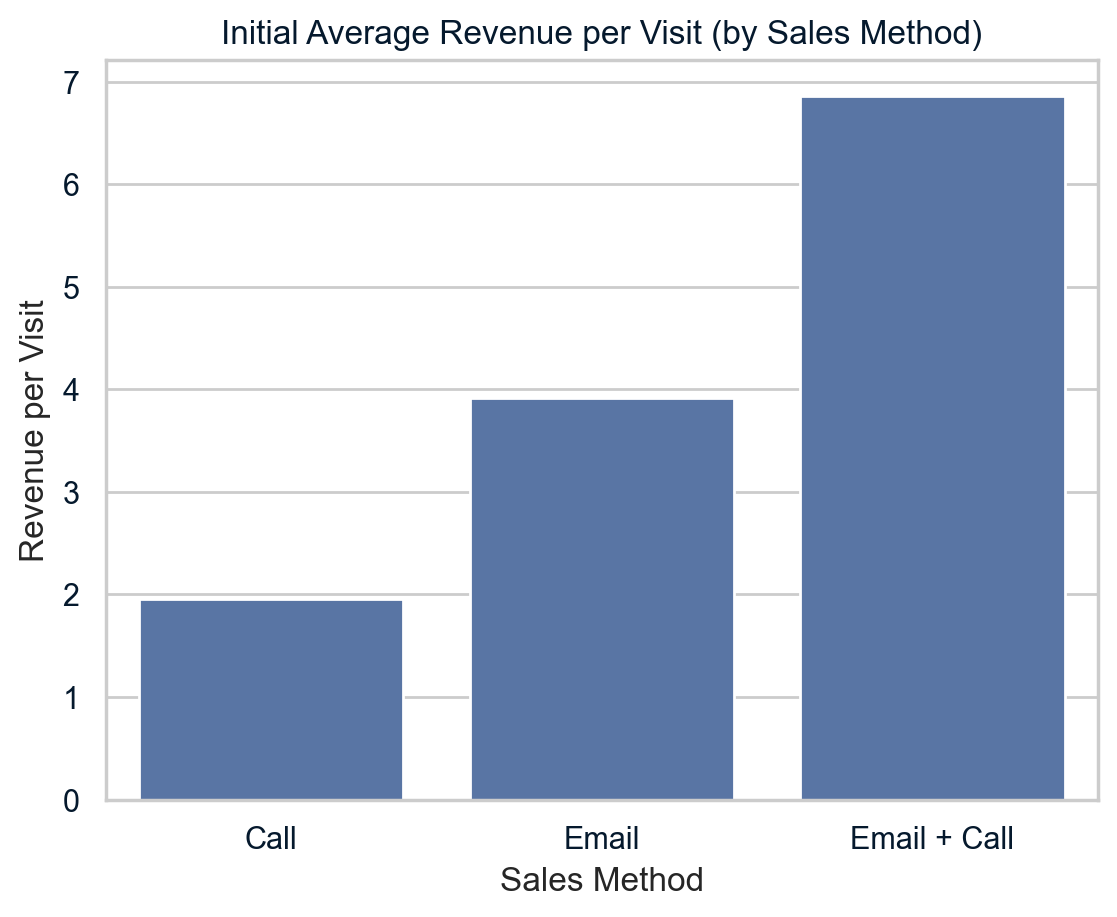

In [43]:
sns.barplot(data=average_revenue_per_visit_by_method)
plt.title('Initial Average Revenue per Visit (by Sales Method)')
plt.xlabel('Sales Method')
plt.ylabel('Revenue per Visit')
plt.show()

## ✅ When you have finished...
-  Publish your Workspace using the option on the left
-  Check the published version of your report:
	-  Can you see everything you want us to grade?
    -  Are all the graphics visible?
-  Review the grading rubric. Have you included everything that will be graded?
-  Head back to the [Certification Dashboard](https://app.datacamp.com/certification) to submit your practical exam report and record your presentation